#**Image Classification Project**

In this project, I will attempt to find the most accurate model to classify images between three sports: soccer (football), baseball, and cricket. I will begin by using logistic regression, and then use the Keras package to try and get the most accurate model possible for the computer to classify the sports.

##Data Loading

In [ ]:
import glob
from PIL import Image
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data is obtained from my google drive and filtered down to the ".jpg" files since there are the most of this kind in all three categories.

In [ ]:
cricket = glob.glob("/content/drive/MyDrive/cricket-football-baseball/cricket/*.jpg")
baseball =  glob.glob("/content/drive/MyDrive/cricket-football-baseball/baseball/*.jpg")
football = glob.glob("/content/drive/MyDrive/cricket-football-baseball/football/*.jpg")

In [ ]:
files = cricket + baseball + football

In [ ]:
img = Image.open(files[0])

We check the image in order to see how it looks, and we do indeed have a man playing cricket.

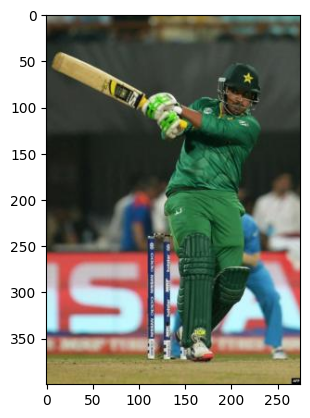

In [ ]:
plt.imshow(img)

In [ ]:
output_width = 200 # Set desired output width
hsize = 200 # Define a corresponding image height that keeps the same aspect ratio
img_resize = img.resize((output_width, hsize), Image.Resampling.LANCZOS)
res = output_width * hsize * 3

We set the variable res, for ease of use later on when reshaping our images later.

<PIL.Image.Image image mode=RGB size=200x200 at 0x7B4B98749BD0>


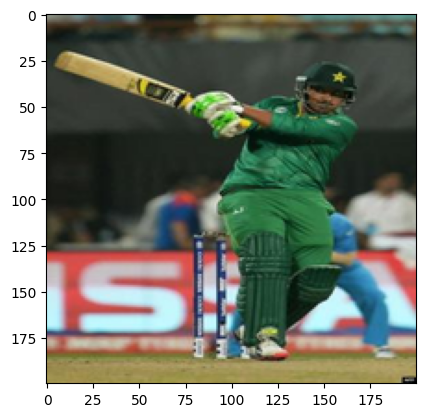

In [ ]:
plt.imshow(img_resize)
print(img_resize)


In [ ]:
img1 = np.array(files[0])
print(img1)


/content/drive/MyDrive/cricket-football-baseball/cricket/0aa39c4a-195e-4b1b-a8ca-2e5ad08b484d.jpg


###Reshaping Data

We must reshape our data here, since the model works on matrices with values between 0 and 1, as well as refining the pixels so that we can have all of the images be the same size. An index for all of the values are also being added, 0 for cricket, 1 for baseball, and 2 for soccer so that we can run a logistic regression for them. This will later be our 'y' variable that we are running the train/ test on.

In [ ]:
crick = np.zeros((len(cricket), res))
index = []
for ii, filepath in enumerate(cricket):
  img = Image.open(filepath)
  img_resized = img.resize((output_width, hsize), Image.Resampling.LANCZOS)

  crick[ii, :] = np.array(img_resized).flatten()
  #print(np.array(img_resized).shape)

  index.append(0)


In [ ]:
base = np.zeros((len(baseball), res))
for ii, filepath in enumerate(baseball):
  img = Image.open(filepath)
  img_resized = img.resize((output_width, hsize), Image.Resampling.LANCZOS)
  #print(img_resized.shape)
  base[ii, :] = np.array(img_resized).flatten()

  #print(np.array(img_resized).shape)

  index.append(1)


In [ ]:
footy = np.zeros((len(football), res))
for ii, filepath in enumerate(football):
  img = Image.open(filepath)
  img_resized = img.resize((output_width, hsize), Image.Resampling.LANCZOS)

  footy[ii, :] = np.array(img_resized).flatten()
  #print(np.array(img_resized).shape)

  index.append(2)


In [ ]:
index = np.array(index)
index.shape

(217,)

In [ ]:
all = np.concatenate((crick,base,footy))
all.shape

(217, 120000)

We notice that the data is all of the same length so we can proceed with the train test split.

###Train Test Split

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(all, index, test_size=.2)

In [ ]:
x_test.shape, x_train.shape, y_test.shape, y_train.shape

((44, 120000), (173, 120000), (44,), (173,))

We have the train and test data of the same size, however, the length for all of these isn't too long which may throw off our results. If there were more data points, it would make it easier to classify our data. To try and help this, I made the resolution larger in an attempt to improve what is seen in the results.

###Normalize

We normalize the data here since in order to make the resolution work, the colors (on a scale of 0 to 255) must be between 0 and 1.

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

#**Analysis**

##Logistic Regression

The model for logistic regression is as follows:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
                        fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #ridge regression
                        solver='saga',
                        max_iter=100,
                        C=50
                      )

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
model.fit(x_train_norm, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=50, solver='saga')

In [ ]:
y_pred = model.predict(x_test_norm)
y_pred.shape

(44,)

In [ ]:
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)

0.5681818181818182


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[13  4  2]
 [ 4  8  2]
 [ 4  3  4]]


As we can see from the accuracy and the confusion matrix, the model does pretty well differentiating cricket from the other two sports, but not as well with soccer and baseball from the other two. However, our model does have 56% accuracy which is better than the 33% accuracy that we would get if we had randomly picked out any image and guesssed which sport it was, so we can say that our model isn't good for nothing, in lieu of a better saying.

##Custom Neural Network

We will now attempt to do the same with the Keras Tuner

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

In [ ]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers  # These are the main hidden layers
    model_layers += [layers.Dense(3)]  # This is the output layer, which should have the same size as the number of classes you are trying to predict
    model = keras.Sequential(model_layers)  # This just stacks all our layers on top of each other
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))  # This is a good loss/penalty function to use for multi-class classification

    return model

We make sure the output layer is set to 3, the amount of sports we have to predict.

In [ ]:
def build_model(hp):
    units = hp.Choice("units", [256, 512])
    activation = "relu"   # We'll just use ReLu for now
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 3, 4])

    # call existing model-building code with the hyperparameter values.
    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss", # We want to see accuracy improve on the validation (or test) dataset
    max_trials=8,  # How many parameter combinations you want to try
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/cricket-football-baseball", # Save the output somewhere you've created
)

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

In [ ]:
tuner.search(
    x_train_norm,
    y_train,
    epochs=8,
    verbose=1,
    validation_data=(x_test_norm, y_test),
    callbacks=callbacks
)

Trial 8 Complete [00h 03m 26s]
val_loss: 1.9372740983963013

Best val_loss So Far: 1.9372740983963013
Total elapsed time: 00h 16m 34s


Now that the models are completed, we find what our best trial is, which is trial #7.

In [ ]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/cricket-football-baseball/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 7 summary
Hyperparameters:
units: 512
lr: 1.6483628864845253e-05
l2: 0.0009523630708434925
num_layers: 2
Score: 1.9372740983963013

Trial 6 summary
Hyperparameters:
units: 512
lr: 0.0005124445794075637
l2: 0.00015866958539134259
num_layers: 3
Score: 5.336620807647705

Trial 0 summary
Hyperparameters:
units: 512
lr: 1.915567221260549e-05
l2: 0.008026920331967533
num_layers: 3
Score: 8.729421615600586

Trial 1 summary
Hyperparameters:
units: 256
lr: 3.6634507094711e-05
l2: 0.02373185351115519
num_layers: 2
Score: 11.309773445129395

Trial 5 summary
Hyperparameters:
units: 512
lr: 6.325279097886842e-05
l2: 0.013056589313979636
num_layers: 3
Score: 11.76196575164795


In [ ]:
import json
from sklearn.metrics import confusion_matrix

trial_num = "7"
with open(f"/content/drive/MyDrive/cricket-football-baseball/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/cricket-football-baseball/untitled_project/trial_{trial_num}/checkpoint")

We print out the accuracy for trial 7 since this is our best trial.

In [ ]:
y_pred = np.argmax(model.predict(x_test_norm), axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)
print(cm)

2/2 [==============================] - 1s 62ms/step
0.5681818181818182
[[18  1  0]
 [ 7  4  3]
 [ 3  5  3]]


Our accuracy here is 57% when rounded up, which unfortunately isn't much better than when we used logistic regression. A similar issue as before might have occurred as before where our model doesn't have many data points, and is guessing a lot of the images to be cricket, hence it shows a better accuraccy in this model for cricket, but this is just because it is guessing cricket more than with the other sports.

#**Conclusion**

Our overall results do show an improved guess on randomly guessing sports, however it is clearly not the best possible. Had the data set included more images, the data may have been more interpretable by the models used. Most of the models that are tested in this way use datasets with thousands of images which creates a more accurate model. Furthermore, there is a lot of background noise apart from the image of he sportsman including grass and crowd noise which may throw off the guesses for all. If the data just included relavent information portraying to the sport, it may have done better as well.